# Recommendation systems 

A recommender system is a simple algorithm whose aim is to provide the most relevant information to a user by discovering patterns in a dataset. The algorithm rates the items and shows the user the items that they would rate highly. 

An example of recommendation in action is when you visit Amazon and you notice that some items are being recommended to you or when Netflix recommends certain movies to you. They are also used by Music streaming applications such as Spotify and Deezer to recommend music that you might like.

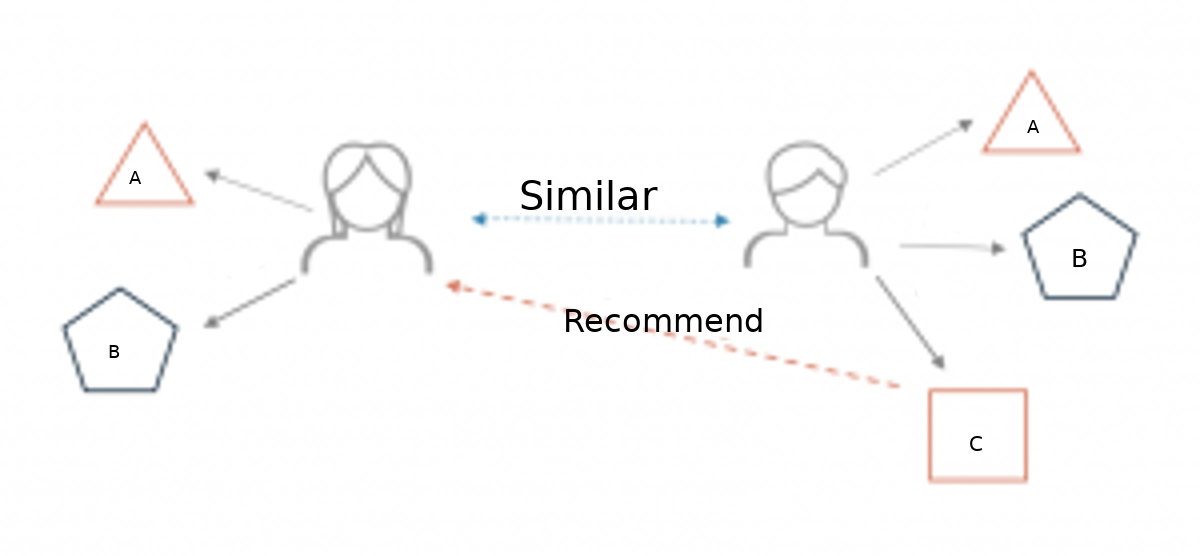

## The Need of Recommendation systems

- With the huge number of choices available to users, there is a need for relevant information on items. Recommendation systems can study user preferences to prioritize and recommend items which the users would like.
- Recommendations systems are a big value-add for large companies like Google, Amazon, Facebook, Netflix etc. as they drive significant customer engagement and revenue.
- Most of the movies that users watch on Netflix, Amazon prime are from recommendation algorithms.

## Abstract :

- Here in this project I want to focus on Book Recommendations.
- I use dataset obtained from  http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Below are recommendation methods I would like to use and come up with predictions.

#### Popularity-based.
-	Get the list of books based on popularity ratings.
-	Suggest most popular ones.

#### Popularity-based.[localized to country and state]
-	Get the list of books based on popularity ratings in the country/state.
-	Suggest most popular ones in the country/state.

#### Collaborative Filtering Based recommendations. 
- Memory-based: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).

    -   Say we want to decide if we can recommend book1 to user1 .
        -	Find other k-Users with similar behavior as user1.
        -	Using cosine similarity or Pearson correlations of users.
        -	Find the Weighted average of the ratings for the k-users for the book1.
        -	If the rating obtained is higher then we can recommend book1 to user1. 
    
- Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.
    - Used scipy's suprise library to build the model

#### Content Based recommendations.
Say we want to decide if we can recommend book1 to user1.
-	Find other Users history of the ratings, for similar k-books.
    -	Using cosine similarity or Pearson correlations of books.
-	Find the Weighted average of the ratings for the k-books by user1.
-	If the rating obtained is higher than we can recommend book1 to user1. 

#### Hybrid Approach.
-	Brings together techniques implemented in the content based and collaborative filter based engines.

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

from warnings import filterwarnings
filterwarnings('ignore')

## Loading Data

In [2]:
# Load Data - Fix Column names , rmove any special character 
# Users Data
Usercolumns = ['UserID', 'Location', 'Age']
users_df = pd.read_csv('Data/BX-Users.csv',sep=';', encoding='latin-1')
users_df.columns = Usercolumns
print(users_df.columns)

# Books Data
Bookcolumns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher',
       'ImageURLS', 'ImageURLM', 'ImageURLL']
books_df = pd.read_csv('Data/BX-Books.csv' , sep=';', encoding='latin-1', error_bad_lines=False)
books_df.columns = Bookcolumns
print(books_df.columns)
# Ratings Data
RatingsColumns = ["UserID","ISBN","BookRating"]
ratings_df = pd.read_csv('Data/BX-Book-Ratings.csv' , sep=';', encoding='latin-1', error_bad_lines=False)
ratings_df.columns = RatingsColumns
print(ratings_df.columns)

Index(['UserID', 'Location', 'Age'], dtype='object')


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


Index(['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher',
       'ImageURLS', 'ImageURLM', 'ImageURLL'],
      dtype='object')
Index(['UserID', 'ISBN', 'BookRating'], dtype='object')


In [3]:
# Print Shapes.
print(" Users DataFrame shape " , users_df.shape)
print(" Books DataFrame shape " , books_df.shape)
print(" Ratings DataFrame shape " , ratings_df.shape)

 Users DataFrame shape  (278858, 3)
 Books DataFrame shape  (271360, 8)
 Ratings DataFrame shape  (1149780, 3)


## Data Wrangling

### Users Data :
#####  - Age column contains NaN value, fill this with mean of Ages from 10 - 90.
#####  - Split the location information in to City , state and country . We may use in the analysis and Drop location column

In [4]:
# Lets Analyse Data in each Data Frame Independantly
users_df.head()

,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
# Fill 
#sorted(users_df.loc[: ,'Age'].unique())
mean_age = np.mean(users_df.loc[(users_df['Age'] > 10) | (users_df['Age'] < 91),'Age'])
users_df.Age.fillna(mean_age,inplace=True)
users_df['Age'] = users_df.Age.astype(int)
users_df.loc[(users_df['Age'] == np.NaN)]

,UserID,Location,Age


In [6]:
# Split the location information in to City , state and country . We may use in the analysis
split_data = users_df["Location"].str.split(", ",3)
data = split_data.to_list()
new_df = pd.DataFrame(data)

users_df["City"] = new_df[0]
users_df["State"] = new_df[1]
users_df["Country"] = new_df[2]

users_df.drop(['Location'], axis=1,inplace=True)
users_df.head(10)

,UserID,Age,City,State,Country
0,1,34,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,34,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,34,farnborough,hants,united kingdom
5,6,61,santa monica,california,usa
6,7,34,washington,dc,usa
7,8,34,timmins,ontario,canada
8,9,34,germantown,tennessee,usa
9,10,26,albacete,wisconsin,spain


### Books Data :
#####  - We dont need URLs for data Analysis Lets drop them.
#####  - YearOfPublication contains some invalid entries should fix it.
#####  - There are many entried with Year-Of-Publication as 0 - is invalid, hence i will replace these values with mean of the values.
#####  - in Publisher column change NaN entries to "Other"

In [7]:
# Above We see that some columns are dropped as there were errors.

# We dont need URLs for data Analysis Lets drop them.
books_df.drop(columns=['ImageURLS','ImageURLM' , 'ImageURLL'], axis=1, inplace=True)
books_df.head()

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [8]:
# Lets analyse Year-Publication

books_df['YearOfPublication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [9]:
# We can see some invalid years like 0 , 'DK Publishing Inc' , 'Gallimard' 
# Lets fix these issues and change this coloumn Data type to number
pd.set_option('display.max_colwidth', -1)
#print(books_df[books_df['Year-Of-Publication'] == 'DK Publishing Inc'])

#books_df.loc[books_df['Year-Of-Publication'] == 'DK Publishing Inc',:]
books_df.loc[209538]['BookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"
books_df.loc[209538]['BookAuthor'] = "Michael Teitelbaum"
books_df.loc[209538]['YearOfPublication'] = "2000"
books_df.loc[209538]['Publisher'] = "DK Publishing Inc"

books_df.loc[221678]['BookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
books_df.loc[221678]['BookAuthor'] = "James Buckley"
books_df.loc[221678]['YearOfPublication'] = "2000"
books_df.loc[221678]['Publisher'] = "DK Publishing Inc"

books_df.loc[[209538,221678]]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [10]:
pd.set_option('display.max_colwidth', -1)
#print(books_df[books_df['Year-Of-Publication'] == 'DK Publishing Inc'])

books_df.loc[220731]['BookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"
books_df.loc[220731]['BookAuthor'] = "Jean-Marie Gustave Le"
books_df.loc[220731]['YearOfPublication'] = "2003"
books_df.loc[220731]['Publisher'] = "Gallimard"

books_df.loc[[220731]]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le,2003,Gallimard


In [11]:
books_df['YearOfPublication'] = pd.to_numeric(books_df['YearOfPublication'])

#books_df.dtypes

print(sorted(books_df['YearOfPublication'].unique()))

print(books_df[books_df['YearOfPublication'] == 0].count())

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]
ISBN                 4618
BookTitle            4618
BookAuthor           4618
YearOfPublication    4618
Publisher            4618
dtype: int64


In [12]:
# There are many entried with Year-Of-Publication as 0 , which is invalid, hence i will replace these values with mean of the values.

books_df.loc[books_df['YearOfPublication'] == 0] = np.mean(books_df['YearOfPublication'])
books_df['YearOfPublication'] = books_df['YearOfPublication'].astype(int)
print(sorted(books_df['YearOfPublication'].unique()))

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [13]:
#print(books_df.loc[books_df['Publisher'].isna(),:])

# We can see some HTML encoded strings like &amp; in 4th row
books_df.loc[128890 : 'Publisher'] = 'Other' 
books_df.loc[129037 :'Publisher'] = 'Other' 

print(books_df.loc[books_df['Publisher'].isna(),:])

Empty DataFrame
Columns: [ISBN, BookTitle, BookAuthor, YearOfPublication, Publisher]
Index: []


### Ratings Data :
#####  - In ratings check if the book and User exists in our users_df and books_df, else drop those records
#####  - Some ratings are 0 in the BookRatings column which means those are implict ratings. We should use only explict ratings for recommendations.

In [14]:
# out these ratings check if the book and User exists in our users_df and books_df, retian on those records
''' Running below method to remove the users rating takes huge time , method below that is pretty fast'''
def KeepValidRatings(ratings_df) :
    cnt = 0;
    for i in range(len(ratings_df)) :
        if ratings_df.loc[i]['UserID'] not in list(users_df['UserID']) or ratings_df.loc[i]['ISBN'] not in list(books_df['ISBN']) :
            ratings_df.drop(index = i, axis=0,inplace=True)
            #print(ratings_df.loc[i ,'User-ID'])
            #print(ratings_df.loc[i]['User-ID'])
            cnt = cnt + 1
    print("Count : " + str(cnt) )


print(" Ratings shape ealier : ",  ratings_df.shape)

#users_df['UserID'] = users_df['User-ID']
#ratings_df['UserID'] = ratings_df['User-ID']

ratings_new = ratings_df[ratings_df.ISBN.isin(books_df.ISBN)]
ratings_df = ratings_new[ratings_new.UserID.isin(users_df.UserID)]

print( " Ratings shape After : " , ratings_df.shape)

ratings_df.head()

 Ratings shape ealier :  (1149780, 3)
 Ratings shape After :  (813587, 3)


,UserID,ISBN,BookRating
0,276725,034545104X,0
2,276727,0446520802,0
5,276733,2080674722,0
8,276744,038550120X,7
10,276746,0425115801,0


In [15]:
ratings_df.BookRating.unique()

array([ 0,  7,  9,  8,  6,  5, 10,  3,  4,  2,  1], dtype=int64)

In [16]:
# Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation),
# or implicit, expressed by 0.
# Ratings are from 1 - 10 are explict ratings, we should use these for recommendations.

#ratings_0 = ratings_df.loc[ratings_df.BookRating == 0]
ratings_x = ratings_df.loc[ratings_df.BookRating != 0]

#ratings_df = ratings_df.loc[ratings_df.UserID.isin(ratings_x.UserID)]
ratings_df = ratings_x
ratings_df.head()
#ratings_df.reset_index()

,UserID,ISBN,BookRating
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
24,276748,0747558167,6


Now that We have cleaned up the users, books and ratings datasets.
Below are final Datasets we have for recommendations.

In [17]:
print("Users Dataset....")
print(users_df.head())
print("Books Dataset....")
print(books_df.head())
print("Ratings Dataset....")
print(ratings_df.head())

Users Dataset....
   UserID  Age         City            State         Country
0  1       34   nyc          new york         usa           
1  2       18   stockton     california       usa           
2  3       34   moscow       yukon territory  russia        
3  4       17   porto        v.n.gaia         portugal      
4  5       34   farnborough  hants            united kingdom
Books Dataset....
         ISBN  \
0  0195153448   
1  0002005018   
2  0060973129   
3  0374157065   
4  0393045218   

                                                                                            BookTitle  \
0  Classical Mythology                                                                                  
1  Clara Callan                                                                                         
2  Decision in Normandy                                                                                 
3  Flu: The Story of the Great Influenza Pandemic of 1918 and the Search fo

## Data Clean UP
##### - Facing memory related issues due to huge dataset
##### - Create one data frame - with all required coloumns
##### - Keep only the rows with users who have atleast rated 100 movies and movies atleast rated by 100 users.

In [18]:
user_counts = ratings_df['UserID'].value_counts()
ratings = ratings_df[ratings_df.UserID.isin(user_counts[user_counts >= 100].index)]

print(ratings.shape)

book_counts = ratings['BookRating'].value_counts()
ratings = ratings[ratings.BookRating.isin(book_counts[book_counts >= 100].index)]

print(ratings.shape)
print(ratings.head())

(68133, 3)
(68133, 3)
      UserID        ISBN  BookRating
1456  277427  002542730X  10        
1461  277427  0060006641  10        
1465  277427  0060542128  7         
1474  277427  0061009059  9         
1488  277427  0140283374  6         


In [19]:
rating_matrix = ratings.pivot(index='UserID',columns='ISBN',values='BookRating').fillna(0)
mat_book_features = csr_matrix(rating_matrix.values)

print(rating_matrix.shape)
rating_matrix.head()

(306, 40182)


ISBN,000104687X,0001047213,0001047973,0001048082,0001056107,0001845039,0001953877,0002005018,0002005050,0002006588,...,9997409728,9997411757,999750805X,9997519086,9997555635,9998914140,B00001U0CP,B00008RWPV,B00009NDAN,B0000VZEJQ
UserID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualizations

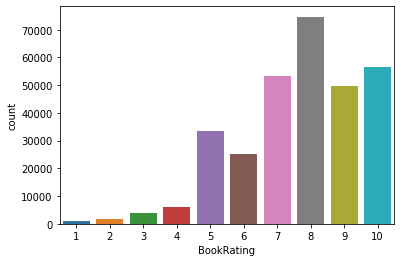

In [20]:
sns.countplot(ratings_df.BookRating)
plt.show()

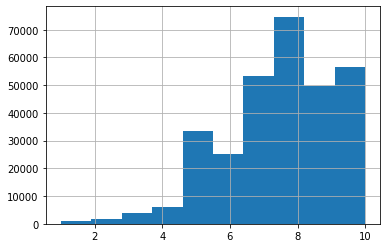

In [21]:
ratings_df.BookRating.hist()
plt.show()

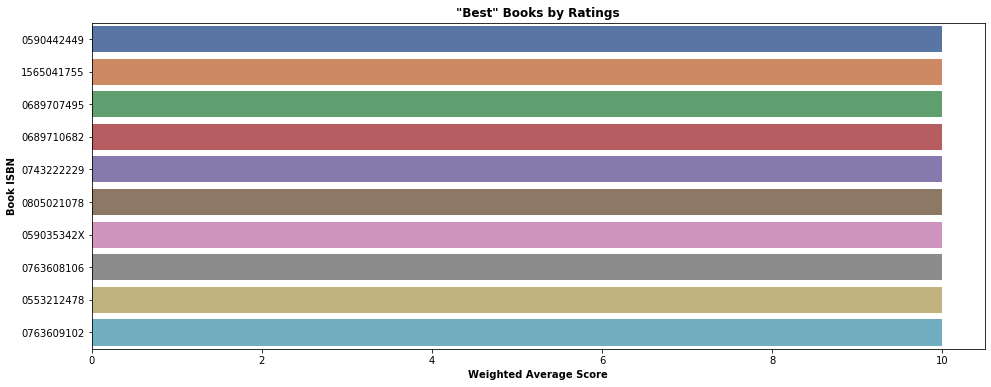

In [22]:
wavg = ratings_df.sort_values('BookRating', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=wavg['BookRating'].head(100), y=wavg['ISBN'].head(10), data=wavg, palette='deep')

plt.title('"Best" Books by Ratings', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Book ISBN', weight='bold')
plt.show()

## Recommendation Models

### Popularity Based Recommendation

#### These is memory based recommendations , based on querying the dataset
> Get the list of books based on popularity ratings.
> Suggest most popular ones.

> We can also use the columns like "State" and "Country" to provide list of recomendations

In [23]:
top10_books_ISBN = pd.DataFrame(ratings_df.groupby(by='ISBN')['BookRating'].sum())
top10_books_ISBN.sort_values('BookRating',ascending=False,inplace=True)
top10_books_Pop_based = pd.merge(top10_books_ISBN,books_df,on='ISBN')

top10_books_Pop_based.head(10)

,ISBN,BookRating,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0316666343,5787,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0385504209,4108,The Da Vinci Code,Dan Brown,2003,Doubleday
2,0312195516,3134,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
3,059035342X,2798,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
4,0142001740,2595,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
5,0971880107,2551,Wild Animus,Rich Shapero,2004,Too Far
6,0060928336,2524,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
7,0446672211,2402,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
8,0452282152,2219,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
9,0671027360,2179,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [24]:
# Based on Country

def GetTop10BooksByCountry(country) :
    ratings_users_df = pd.merge(ratings_df,users_df,on='UserID')
    ratings_users_books_df = pd.merge(ratings_users_df,books_df,on='ISBN')
    ratings_users_books_df_country = ratings_users_books_df.loc[ratings_users_books_df['Country'] == country]
    ratings = pd.DataFrame(ratings_users_books_df_country.groupby(by=['ISBN'])['BookRating'].sum())
    ratings.sort_values('BookRating',ascending=False,inplace=True)
    top10_country = pd.merge(ratings,books_df,on='ISBN')
    
    return top10_country


GetTop10BooksByCountry('usa').head(10)

,ISBN,BookRating,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0316666343,4348,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0385504209,3320,The Da Vinci Code,Dan Brown,2003,Doubleday
2,0312195516,2457,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
3,059035342X,2400,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
4,0142001740,2296,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
5,0060928336,2120,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
6,0446672211,1847,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
7,0671027360,1831,Angels &amp; Demons,Dan Brown,2001,Pocket Star
8,044023722X,1751,A Painted House,John Grisham,2001,Dell Publishing Company
9,0452282152,1719,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


In [25]:
# Based on Country and State

def GetTop10BooksByCountryState(country,state) :
    ratings_users_df = pd.merge(ratings_df,users_df,on='UserID')
    ratings_users_books_df = pd.merge(ratings_users_df,books_df,on='ISBN')
    ratings_users_books_df_country = ratings_users_books_df.loc[ratings_users_books_df['Country'] == country]
    ratings_users_books_df_country_state = ratings_users_books_df_country.loc[ratings_users_books_df['State'] == state]
    
    ratings = pd.DataFrame(ratings_users_books_df_country_state.groupby(by=['ISBN'])['BookRating'].sum())
    ratings.sort_values('BookRating',ascending=False,inplace=True)
    top10_country = pd.merge(ratings,books_df,on='ISBN')
    
    return top10_country


GetTop10BooksByCountryState('usa','washington').head(10)

,ISBN,BookRating,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0316666343,149,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0312195516,107,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2,0142001740,102,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
3,0452282152,100,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
4,0060928336,93,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
5,0440211727,86,A Time to Kill,JOHN GRISHAM,1992,Dell
6,059035342X,81,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
7,0804106304,79,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12)
8,0316601950,76,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books
9,067976402X,75,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA


## Collaborative Filtering based Recommendation

This has mainly two methods :

- Memory-based: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).

- Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.


- Below implementation is based on "Memory-based" approach
>  Say we want to decide if we can recommend book1 to user1 .
>  - Find other k-Users with similar behavior as user1. Using cosine similarity or Pearson correlations of users.
>  - Find the Weighted average of the ratings for the k-users for the book1.
>  - If the rating obtained is higher then we can recommend book1 to user1.

In [26]:
# Get similar users.
from sklearn.neighbors import NearestNeighbors

def findksimilarusers(userid, ratings, metric='cosine', k=10):
    similarities=[]
    indices=[]
    loc = ratings.index.get_loc(userid)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

findksimilarusers(11676,rating_matrix)

(array([1.        , 0.09387204, 0.08966543, 0.0840238 , 0.07830615,
        0.07687119, 0.07345007, 0.07037493, 0.069867  , 0.06832764,
        0.06740861]),
 array([[ 17, 140,  28, 128, 281, 150,  94,  32, 182, 171, 146]],
       dtype=int64))

In [27]:
def CollabarativeFilteringBasedPrediction(userid,isbn,ratings,metric):
    prediction=0
    user_loc = ratings.index.get_loc(userid)
    item_loc = ratings.columns.get_loc(isbn)
    similarities, indices=findksimilarusers(userid, ratings,metric) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities) - 1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    #print("\nPredicted rating for user {0} -> item {1}: {2}".format(userid,isbn,prediction))

    return prediction

In [28]:
userid = 11676
isbn = '0001056107'
pred_rating = CollabarativeFilteringBasedPrediction(userid,isbn,rating_matrix,'cosine')
print("\nPredicted rating for user {0} -> item {1}: {2}".format(userid,isbn,pred_rating))


Predicted rating for user 11676 -> item 0001056107: 2


In [29]:
# among top10_books_Pop_based , how many we can recommend to userid 11676
def top10BookRecommendationsCollabarativeFilteringBased(userid,books,ratings,metric):
    cols = ['ISBN','Title','Predicted_rating']
    recommendedBooks = pd.DataFrame(columns=cols)
    count1 = 0
    for i in range(0,len(books)) :
        pred_rating = CollabarativeFilteringBasedPrediction(userid,books[i],ratings,metric)
        if count1 >= 10:
            break
   
        if pred_rating > 3:
            title = (books_df[books_df['ISBN'] == books[i]]['BookTitle']).values[0]
            row_dict = {'ISBN': books[i], 'Title': title, 'Predicted_rating': pred_rating}
            recommendedBooks.loc[len(recommendedBooks)] = row_dict
            count1 += 1
    print("Count {0}".format(count1))
    recommendedBooks.sort_values(by='Predicted_rating',ascending=False,inplace=True)
    return recommendedBooks

In [30]:
# Below are the recommended Books for the user based on cosine similarty
userid = 11676
popular_books = list(top10_books_Pop_based['ISBN'])
recommendedBooks = top10BookRecommendationsCollabarativeFilteringBased(userid,popular_books,rating_matrix,'cosine')
print("As per Content Based approach. Following books are recommended to user {0} from popular books...\n".format(userid))
for i in range(0,len(recommendedBooks)):
     print("{0}.{1}".format(i+1,recommendedBooks.iloc[i].Title))

Count 10
As per Content Based approach. Following books are recommended to user 11676 from popular books...

1.1st to Die: A Novel
2.The Lovely Bones: A Novel
3.The Red Tent (Bestselling Backlist)
4.House of Sand and Fog
5.Summer Sisters
6.A Time to Kill
7.White Oleander : A Novel (Oprah's Book Club)
8.The Pelican Brief
9.One for the Money (Stephanie Plum Novels (Paperback))
10.The Hours: A Novel


In [31]:
# Below are the recommended Books for the user based on correlation similarty
userid = 11676
popular_books = list(top10_books_Pop_based['ISBN'])
recommendedBooks = top10BookRecommendationsCollabarativeFilteringBased(userid,popular_books,rating_matrix,'correlation')
print("As per Content Based approach. Following books are recommended to user {0} from popular books...\n".format(userid))
for i in range(0,len(recommendedBooks)):
     print("{0}.{1}".format(i+1,recommendedBooks.iloc[i].Title))

Count 10
As per Content Based approach. Following books are recommended to user 11676 from popular books...

1.Two for the Dough
2.The Red Tent (Bestselling Backlist)
3.She's Come Undone (Oprah's Book Club (Paperback))
4.1st to Die: A Novel
5.White Oleander : A Novel (Oprah's Book Club)
6.The Pelican Brief
7.The Client
8.Cold Mountain : A Novel
9.Harry Potter and the Goblet of Fire (Book 4)
10.The Alienist


###### - Below implementation is based on "Memory-based" approach

In [32]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [33]:
# surprise reader API to read the dataset
reader = Reader()

In [34]:
ratings_df.head()

,UserID,ISBN,BookRating
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
24,276748,0747558167,6


In [35]:
data = Dataset.load_from_df(ratings_df[['UserID', 'ISBN', 'BookRating']], reader)

In [36]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([3.2164605 , 3.21984938, 3.22568522, 3.22660658, 3.22037436]),
 'test_mae': array([2.81198617, 2.81262851, 2.81780396, 2.82308638, 2.81527229]),
 'fit_time': (32.20826721191406,
  31.4189715385437,
  31.359018325805664,
  32.03388166427612,
  32.245545864105225),
 'test_time': (1.2355499267578125,
  0.9273254871368408,
  0.9137136936187744,
  0.9452617168426514,
  0.9381532669067383)}

In [37]:
trainset = data.build_full_trainset()
#svd.train(trainset)

In [38]:
def top10BookRecommendationsCFModelBased(userid,books):
    cols = ['ISBN','Title','Predicted_rating']
    recommendedBooks = pd.DataFrame(columns=cols)
    count2 = 0
    for i in range(0,len(books)) :
        pred_rating = int(svd.predict(userid, books[i]).est)
        if count2 >= 10:
            break
   
        if pred_rating > 4:
            title = (books_df[books_df['ISBN'] == books[i]]['BookTitle']).values[0]
            row_dict = {'ISBN': books[i], 'Title': title, 'Predicted_rating': pred_rating}
            recommendedBooks.loc[len(recommendedBooks)] = row_dict
            count2 += 1
    print("Count {0}".format(count2))
    recommendedBooks.sort_values(by='Predicted_rating',ascending=False,inplace=True)
    return recommendedBooks

###### Below are the recommended Books for the user based on model based CF

In [39]:
userid = 11676
popular_books = list(top10_books_Pop_based['ISBN'])
recommendedBooks = top10BookRecommendationsCFModelBased(userid,popular_books)
print("As per Content Based approach. Following books are recommended to user {0} from popular books...\n".format(userid))
for i in range(0,len(recommendedBooks)):
     print("{0}.{1}".format(i+1,recommendedBooks.iloc[i].Title))

Count 10
As per Content Based approach. Following books are recommended to user 11676 from popular books...

1.The Da Vinci Code
2.The Red Tent (Bestselling Backlist)
3.Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
4.The Secret Life of Bees
5.Wild Animus
6.Divine Secrets of the Ya-Ya Sisterhood: A Novel
7.Where the Heart Is (Oprah's Book Club (Paperback))
8.Girl with a Pearl Earring
9.Angels &amp; Demons
10.A Painted House


## Content Based recommendations.
>  Say we want to decide if we can recommend book1 to user1.
>  - Find other Users history of the ratings, for similar k-books.Using cosine similarity or Pearson correlations of books.
>  - Find the Weighted average of the ratings for the k-books by user1.
>  - If the rating obtained is higher ( > 6) then we can recommend book1 to user1.

In [40]:
from sklearn.neighbors import NearestNeighbors

def findksimilarbooks(isbn, ratings, metric='cosine', k=10):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(isbn)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

findksimilarbooks('0001056107',rating_matrix)

(array([1.        , 0.99227788, 0.87811408, 0.73582366, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678]),
 array([[    4, 37447, 30531,  1306, 11227, 17050, 14528, 27358, 36819,
          4755,  4740]], dtype=int64))

In [41]:
def ContentBasedPrediction(userid , isbn, ratings,metric):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(userid)
    book_loc = ratings.columns.get_loc(isbn)
    #Get similar books
    similarities,indices = findksimilarbooks(isbn,rating_matrix,metric)
    
    # predict userid rating for this isbn based on userid ratings's for similar books
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == book_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    return prediction

In [42]:
userid = 11676
isbn = '0001056107'
pred_rating = ContentBasedPrediction(userid,isbn,rating_matrix,'cosine')
print("\nPredicted rating for user {0} -> item {1}: {2}".format(userid,isbn,pred_rating))


Predicted rating for user 11676 -> item 0001056107: 1


In [43]:
# among top10_books_Pop_based , how many we can recommend to userid 11676
def top10BookRecommendationsContentBased(books,userid,ratings,metric):
    cols = ['ISBN','Title','Predicted_rating']
    recommendedBooks = pd.DataFrame(columns=cols)
    count = 0
    for book in books :
        pred_rating = ContentBasedPrediction(userid,book,ratings,metric)
        if count >= 10:
            break
        if pred_rating > 6:
            title = (books_df[books_df['ISBN'] == book]['BookTitle']).values[0]
            row_dict = {'ISBN': book, 'Title': title, 'Predicted_rating': pred_rating}
            recommendedBooks.loc[len(recommendedBooks)] = row_dict
            count += 1

    recommendedBooks.sort_values(by='Predicted_rating',ascending=False,inplace=True)
    return recommendedBooks

##### Below are the recommended Books for the user based on cosine similarty

In [44]:
userid = 11676
popular_books = list(top10_books_Pop_based['ISBN'])
recommendedBooks = top10BookRecommendationsContentBased(popular_books,userid,rating_matrix,'cosine')
print("As per Content Based approach. Following books are recommended to user {0} from popular books...\n".format(userid))
for i in range(0,len(recommendedBooks)):
     print("{0}.{1}".format(i+1,recommendedBooks.iloc[i].Title))

As per Content Based approach. Following books are recommended to user 11676 from popular books...

1.Timeline
2.Fast Food Nation: The Dark Side of the All-American Meal
3.Harry Potter and the Chamber of Secrets (Book 2)
4.1st to Die: A Novel
5.Confessions of a Shopaholic (Summer Display Opportunity)
6.Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
7.Wild Animus
8.Where the Heart Is (Oprah's Book Club (Paperback))
9.The Five People You Meet in Heaven
10.Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)


##### Below are the recommended Books for the user based on correlation similarty

In [45]:
userid = 11676
popular_books = list(top10_books_Pop_based['ISBN'])
# Below are the recommended Books for the user 11676
recommendedBooks = top10BookRecommendationsContentBased(popular_books,userid,rating_matrix,'correlation')
print("As per Content Based approach. Following books are recommended to user {0} from popular books...\n".format(userid))
for i in range(0,len(recommendedBooks)):
     print("{0}.{1}".format(i+1,recommendedBooks.iloc[i].Title))

As per Content Based approach. Following books are recommended to user 11676 from popular books...

1.Timeline
2.Fast Food Nation: The Dark Side of the All-American Meal
3.The Red Tent (Bestselling Backlist)
4.Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
5.Wild Animus
6.Where the Heart Is (Oprah's Book Club (Paperback))
7.The Five People You Meet in Heaven
8.Harry Potter and the Chamber of Secrets (Book 2)
9.Jurassic Park
10.1st to Die: A Novel


## Final Report :

- Did the popularity based recommendation analysis using country and the state infomation of the user.

- Based above analysis there is significant difference between Content Based recommendations and Collaborative Filtering based Recommendation.

- Did both memory based and model based analysis for Collaborative Filtering Recommendations.

- Content Based recommendations predicted the higher rating compared to Collaborative Filtering , for same users and isbn.

- Imporvements to this model :
    - Use different model other than knn and compare the model parameters
    - ensemble models.
    - Hybrid approach (using Content Based recommendations and Collaborative Filtering based Recommendations.)

- Refrences :
    - https://www.coursera.org/lecture/machine-learning-with-python/collaborative-filtering-4y9I1
    - https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847
    - https://github.com/jalajthanaki/Movie_recommendation_engine/blob/master/Movie_recommendation_engine.ipynb